# How to transform data into factors

Based on a conceptual understanding of key factor categories, their rationale and popular metrics, a key task is to identify new factors that may better capture the risks embodied by the return drivers laid out previously, or to find new ones. 

In either case, it will be important to compare the performance of innovative factors to that of known factors to identify incremental signal gains.

We create the dataset here and store it in our [data](../data) folder to facilitate reuse in later chapters.

## Imports & Settings

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
%matplotlib inline

from datetime import datetime
import pandas as pd
import pandas_datareader.data as web

# replaces pyfinance.ols.PandasRollingOLS (no longer maintained)
from statsmodels.regression.rolling import RollingOLS
import statsmodels.api as sm

import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
sns.set_style('whitegrid')
idx = pd.IndexSlice

## Get Data

The `assets.h5` store can be generated using the the notebook [create_datasets](../data/create_datasets.ipynb) in the [data](../data) directory in the root directory of this repo for instruction to download the following dataset.

We load the Quandl stock price datasets covering the US equity markets 2000-18 using `pd.IndexSlice` to perform a slice operation on the `pd.MultiIndex`, select the adjusted close price and unpivot the column to convert the DataFrame to wide format with tickers in the columns and timestamps in the rows:

Set data store location:

In [4]:
DATA_STORE = '../data/assets.h5'

In [5]:
START = 2000
END = 2018

In [6]:
with pd.HDFStore(DATA_STORE) as store:
    prices = (store['quandl/wiki/prices']
              .loc[idx[str(START):str(END), :], 'adj_close']
              .unstack('ticker'))
    stocks = store['us_equities/stocks'].loc[:, ['marketcap', 'ipoyear', 'sector']]

In [7]:
prices.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4706 entries, 2000-01-03 to 2018-03-27
Columns: 3199 entries, A to ZUMZ
dtypes: float64(3199)
memory usage: 114.9 MB


In [8]:
stocks.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6834 entries, PIH to ZYME
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   marketcap  5766 non-null   float64
 1   ipoyear    3038 non-null   float64
 2   sector     5288 non-null   object 
dtypes: float64(2), object(1)
memory usage: 213.6+ KB


### Keep data with stock info

Remove `stocks` duplicates and align index names for later joining.

In [9]:
stocks = stocks[~stocks.index.duplicated()]
stocks.index.name = 'ticker'

Get tickers with both price information and metdata

In [10]:
shared = prices.columns.intersection(stocks.index)

In [11]:
stocks = stocks.loc[shared, :]
stocks.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2412 entries, A to ZUMZ
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   marketcap  2407 non-null   float64
 1   ipoyear    1065 non-null   float64
 2   sector     2372 non-null   object 
dtypes: float64(2), object(1)
memory usage: 75.4+ KB


In [12]:
prices = prices.loc[:, shared]
prices.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4706 entries, 2000-01-03 to 2018-03-27
Columns: 2412 entries, A to ZUMZ
dtypes: float64(2412)
memory usage: 86.6 MB


In [13]:
assert prices.shape[1] == stocks.shape[0]

## Create monthly return series

To reduce training time and experiment with strategies for longer time horizons, we convert the business-daily data to month-end frequency using the available adjusted close price:

In [14]:
prices.head()

ticker,A,AA,AAL,AAMC,AAN,AAOI,AAON,AAP,AAPL,AAT,...,ZEN,ZEUS,ZGNX,ZION,ZIOP,ZIXI,ZNGA,ZOES,ZTS,ZUMZ
date,,,,,,,,,,,,,,,,,,,,,
2000-01-03,49.121329,NaN,NaN,NaN,4.975857,NaN,1.025920,NaN,3.596463,NaN,...,NaN,4.466544,NaN,43.826745,NaN,37.06,NaN,NaN,NaN,NaN
2000-01-04,45.369006,NaN,NaN,NaN,4.958913,NaN,1.068476,NaN,3.293170,NaN,...,NaN,4.466544,NaN,41.702530,NaN,36.50,NaN,NaN,NaN,NaN
2000-01-05,41.998737,NaN,NaN,NaN,4.958913,NaN,1.073796,NaN,3.341362,NaN,...,NaN,4.408079,NaN,41.899948,NaN,37.13,NaN,NaN,NaN,NaN
2000-01-06,40.934441,NaN,NaN,NaN,4.958913,NaN,1.082915,NaN,3.052206,NaN,...,NaN,4.350542,NaN,42.247403,NaN,35.25,NaN,NaN,NaN,NaN
2000-01-07,44.345645,NaN,NaN,NaN,4.958913,NaN,1.044918,NaN,3.196784,NaN,...,NaN,4.640083,NaN,42.350060,NaN,38.00,NaN,NaN,NaN,NaN


In [15]:
monthly_prices = prices.resample('M').last()

To capture time series dynamics that reflect, for example, momentum patterns, we compute historical returns using the method `.pct_change(n_periods)`, that is, returns over various monthly periods as identified by lags.

We then convert the wide result back to long format with the `.stack()` method, use `.pipe()` to apply the `.clip()` method to the resulting `DataFrame`, and winsorize returns at the [1%, 99%] levels; that is, we cap outliers at these percentiles.

Finally, we normalize returns using the geometric average. After using `.swaplevel()` to change the order of the `MultiIndex` levels, we obtain compounded monthly returns for six periods ranging from 1 to 12 months:

In [16]:
monthly_prices.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 219 entries, 2000-01-31 to 2018-03-31
Freq: ME
Columns: 2412 entries, A to ZUMZ
dtypes: float64(2412)
memory usage: 4.0 MB


In [17]:
outlier_cutoff = 0.01
data = pd.DataFrame()
lags = [1, 2, 3, 6, 9, 12]
for lag in lags:
    data[f'return_{lag}m'] = (monthly_prices
                           .pct_change(lag)
                           .stack()
                           .pipe(lambda x: x.clip(lower=x.quantile(outlier_cutoff),
                                                  upper=x.quantile(1-outlier_cutoff)))
                           .add(1)
                           .pow(1/lag)
                           .sub(1)
                           )
data = data.swaplevel().dropna()
data.info()
data.head()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 399525 entries, ('A', Timestamp('2001-01-31 00:00:00')) to ('ZUMZ', Timestamp('2018-03-31 00:00:00'))
Data columns (total 6 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   return_1m   399525 non-null  float64
 1   return_2m   399525 non-null  float64
 2   return_3m   399525 non-null  float64
 3   return_6m   399525 non-null  float64
 4   return_9m   399525 non-null  float64
 5   return_12m  399525 non-null  float64
dtypes: float64(6)
memory usage: 19.9+ MB


,,return_1m,return_2m,return_3m,return_6m,return_9m,return_12m
ticker,date,,,,,,
A,2001-01-31,-0.003653,0.022360,0.056104,0.049811,-0.052500,-0.015988
AAN,2001-01-31,0.116071,0.008439,-0.015687,-0.009856,-0.002912,-0.009572
AAON,2001-01-31,0.300170,0.034296,0.028670,-0.006238,0.010159,0.031027
AAPL,2001-01-31,0.430943,0.144685,0.033941,-0.132736,-0.110514,-0.070339
ABAX,2001-01-31,-0.073762,-0.042573,-0.044914,-0.003738,-0.028353,-0.031993


## Drop stocks with less than 10 yrs of returns

In [18]:
min_obs = 120
nobs = data.groupby(level='ticker').size()
keep = nobs[nobs>min_obs].index

data = data.loc[idx[keep,:], :]
data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 360752 entries, ('A', Timestamp('2001-01-31 00:00:00')) to ('ZUMZ', Timestamp('2018-03-31 00:00:00'))
Data columns (total 6 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   return_1m   360752 non-null  float64
 1   return_2m   360752 non-null  float64
 2   return_3m   360752 non-null  float64
 3   return_6m   360752 non-null  float64
 4   return_9m   360752 non-null  float64
 5   return_12m  360752 non-null  float64
dtypes: float64(6)
memory usage: 18.0+ MB


In [19]:
data.describe()

,return_1m,return_2m,return_3m,return_6m,return_9m,return_12m
count,360752.000000,360752.000000,360752.000000,360752.000000,360752.000000,360752.000000
mean,0.012255,0.009213,0.008181,0.007025,0.006552,0.006296
std,0.114236,0.081170,0.066584,0.048474,0.039897,0.034792
min,-0.329564,-0.255452,-0.214783,-0.162063,-0.131996,-0.114283
25%,-0.046464,-0.030716,-0.023961,-0.014922,-0.011182,-0.009064
50%,0.009448,0.009748,0.009744,0.009378,0.008982,0.008726
75%,0.066000,0.049249,0.042069,0.031971,0.027183,0.024615
max,0.430943,0.281819,0.221789,0.154555,0.124718,0.106371


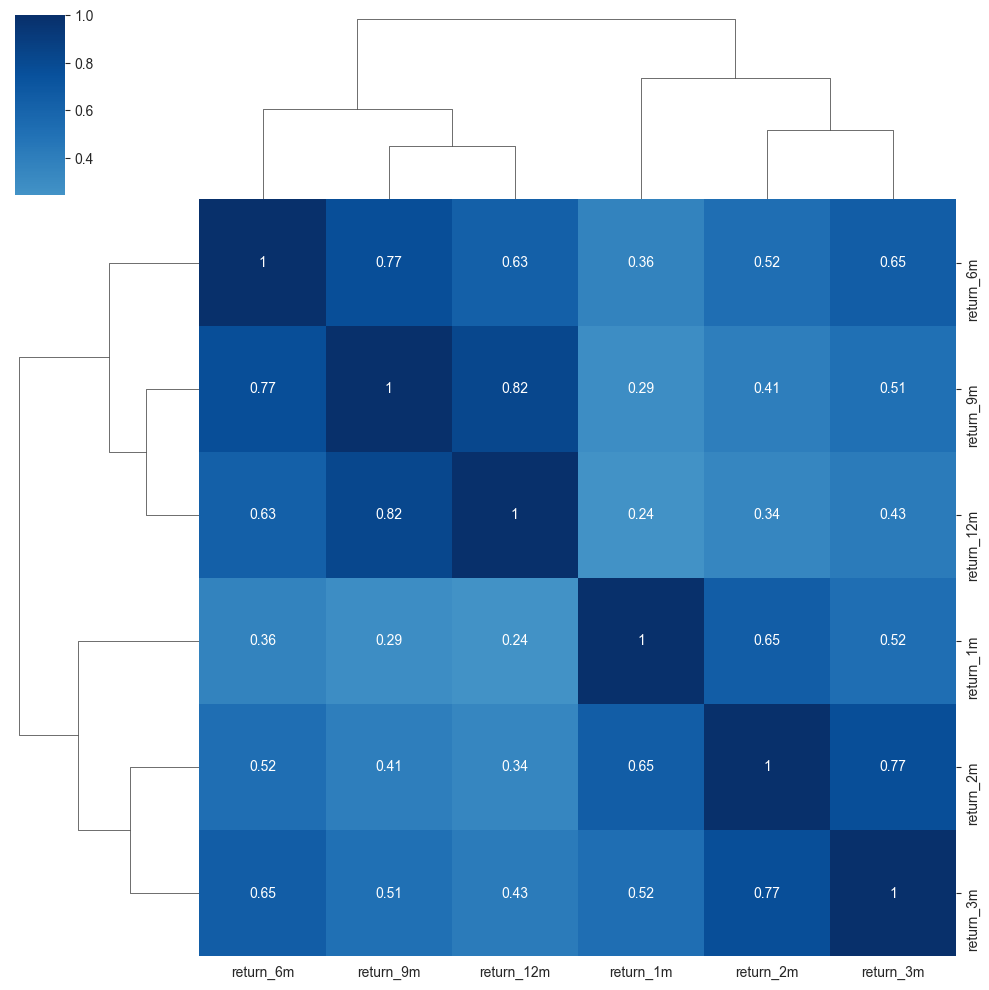

In [20]:
# cmap = sns.diverging_palette(10, 220, as_cmap=True)
sns.clustermap(data.corr('spearman'), annot=True, center=0, cmap='Blues');

We are left with 1,670 tickers.

In [21]:
data.index.get_level_values('ticker').nunique()

1838

## Rolling Factor Betas

We will introduce the Fama—French data to estimate the exposure of assets to common risk factors using linear regression in [Chapter 9, Time Series Models](../09_time_series_models).

The five Fama—French factors, namely market risk, size, value, operating profitability, and investment have been shown empirically to explain asset returns and are commonly used to assess the risk/return profile of portfolios. Hence, it is natural to include past factor exposures as financial features in models that aim to predict future returns.

We can access the historical factor returns using the `pandas-datareader` and estimate historical exposures using the `RollingOLS` rolling linear regression functionality in the `statsmodels` library as follows:

Use Fama-French research factors to estimate the factor exposures of the stock in the dataset to the 5 factors market risk, size, value, operating profitability and investment.

In [22]:
factors = ['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA']
factor_data = web.DataReader('F-F_Research_Data_5_Factors_2x3', 'famafrench', start='2000')[0].drop('RF', axis=1)
factor_data.index = factor_data.index.to_timestamp()
factor_data = factor_data.resample('M').last().div(100)
factor_data.index.name = 'date'
factor_data.info()
factor_data.head()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 311 entries, 2000-01-31 to 2025-11-30
Freq: ME
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Mkt-RF  311 non-null    float64
 1   SMB     311 non-null    float64
 2   HML     311 non-null    float64
 3   RMW     311 non-null    float64
 4   CMA     311 non-null    float64
dtypes: float64(5)
memory usage: 14.6 KB


,Mkt-RF,SMB,HML,RMW,CMA
date,,,,,
2000-01-31,-0.0474,0.0421,-0.0112,-0.0615,0.0456
2000-02-29,0.0245,0.1846,-0.0977,-0.1895,-0.0113
2000-03-31,0.0521,-0.1554,0.0850,0.1165,-0.0120
2000-04-30,-0.0635,-0.0475,0.0645,0.0807,0.0563
2000-05-31,-0.0439,-0.0386,0.0459,0.0405,0.0147


In [23]:
factor_data = factor_data.join(data['return_1m']).sort_index()
factor_data.info()
factor_data.head()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 360752 entries, ('A', Timestamp('2001-01-31 00:00:00')) to ('ZUMZ', Timestamp('2018-03-31 00:00:00'))
Data columns (total 6 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   Mkt-RF     360752 non-null  float64
 1   SMB        360752 non-null  float64
 2   HML        360752 non-null  float64
 3   RMW        360752 non-null  float64
 4   CMA        360752 non-null  float64
 5   return_1m  360752 non-null  float64
dtypes: float64(6)
memory usage: 18.0+ MB


Mkt-RF     SMB     HML     RMW     CMA  return_1m
ticker date                                                         
A      2001-01-31  0.0325  0.0523 -0.0505 -0.0520 -0.0521  -0.003653
       2001-02-28 -0.1003  0.0287  0.1223  0.0912  0.0901  -0.329564
       2001-03-31 -0.0725  0.0233  0.0647  0.0334  0.0372  -0.146389
       2001-04-30  0.0794 -0.0088 -0.0464 -0.0318 -0.0319   0.269444
       2001-05-31  0.0068  0.0355  0.0338  0.0029  0.0195  -0.140220

In [24]:
T = 24
betas = (factor_data.groupby(level='ticker',
                             group_keys=False)
         .apply(lambda x: RollingOLS(endog=x.return_1m,
                                     exog=sm.add_constant(x.drop('return_1m', axis=1)),
                                     window=min(T, x.shape[0]-1))
                .fit(params_only=True)
                .params
                .drop('const', axis=1)))

In [ ]:
betas.describe().join(betas.sum(1).describe().to_frame('total'))
betas.head(30)

Mkt-RF       SMB       HML       RMW       CMA
ticker date                                                        
A      2001-01-31       NaN       NaN       NaN       NaN       NaN
       2001-02-28       NaN       NaN       NaN       NaN       NaN
       2001-03-31       NaN       NaN       NaN       NaN       NaN
       2001-04-30       NaN       NaN       NaN       NaN       NaN
       2001-05-31       NaN       NaN       NaN       NaN       NaN
       2001-06-30       NaN       NaN       NaN       NaN       NaN
       2001-07-31       NaN       NaN       NaN       NaN       NaN
       2001-08-31       NaN       NaN       NaN       NaN       NaN
       2001-09-30       NaN       NaN       NaN       NaN       NaN
       2001-10-31       NaN       NaN       NaN       NaN       NaN
       2001-11-30       NaN       NaN       NaN       NaN       NaN
       2001-12-31       NaN       NaN       NaN       NaN       NaN
       2002-01-31       NaN       NaN       NaN       NaN       NaN
       2002-02-28       NaN       NaN       NaN       NaN       NaN
       2002-03-31       NaN       NaN       NaN       NaN       NaN
       2002-04-30       NaN       NaN       NaN       NaN       NaN
       2002-05-31       NaN       NaN       NaN       NaN       NaN
       2002-06-30       NaN       NaN       NaN       NaN       NaN
       2002-07-31       NaN       NaN       NaN       NaN       NaN
       2002-08-31       NaN       NaN       NaN       NaN       NaN
       2002-09-30       NaN       NaN       NaN       NaN       NaN
       2002-10-31       NaN       NaN       NaN       NaN       NaN
       2002-11-30       NaN       NaN       NaN       NaN       NaN
       2002-12-31  1.597517  0.856499 -1.418389 -0.711709  1.235133
       2003-01-31  1.582381  1.056861 -1.418003 -0.787698  0.911815
       2003-02-28  1.651487  1.166887 -1.158356 -0.730898  1.064119
       2003-03-31  1.645888  1.158865 -1.157493 -0.748250  1.073382
       2003-04-30  1.436836  1.188921 -0.756213 -1.032786  1.160571
       2003-05-31  1.478070  1.241641 -0.462433 -0.897334  0.962950
       2003-06-30  1.524851  1.401069 -0.538232 -0.784254  0.844669
       2003-07-31  1.504868  1.394110 -0.543633 -0.801592  0.819896
       2003-08-31  1.482977  1.401912 -0.502029 -0.841898  0.874298
       2003-09-30  1.454983  1.359089 -0.494696 -0.869960  0.933298
       2003-10-31  1.376830  1.189304 -0.207348 -0.994208  1.038956
       2003-11-30  1.284714  1.500163 -0.895452 -0.747460  1.578224
       2003-12-31  1.361068  1.482087 -0.834880 -0.693392  1.502810
       2004-01-31  1.031812  1.223446 -0.380825 -1.376910  1.580582
       2004-02-29  0.615729  1.306890 -0.030636 -2.438567  0.386393
       2004-03-31  0.581386  1.205501  0.030375 -2.485168  0.508342
       2004-04-30  0.796739  1.673867 -0.222312 -1.405831  1.954317
       2004-05-31  0.810666  1.417332 -0.084787 -1.083375  2.721767
       2004-06-30  1.046509  2.331446 -1.104829  1.217948  5.969499
       2004-07-31  1.210427  2.556941 -0.878959  1.196153  5.562864
       2004-08-31  1.143322  2.077416  0.397057  0.057656  3.667809
       2004-09-30  2.096128  2.166359  0.028167  0.940985  4.196341
       2004-10-31  2.089306  2.053383 -0.116937  0.988652  4.378123
       2004-11-30  1.670050  1.387605  0.087509  0.793074  4.163017
       2004-12-31  1.896871  1.021115 -0.234315  0.473710  4.120284
       2005-01-31  1.483186  0.914007 -0.008244  0.091412  3.974200
       2005-02-28  1.197516  0.513552 -0.394261 -0.115315  4.208656

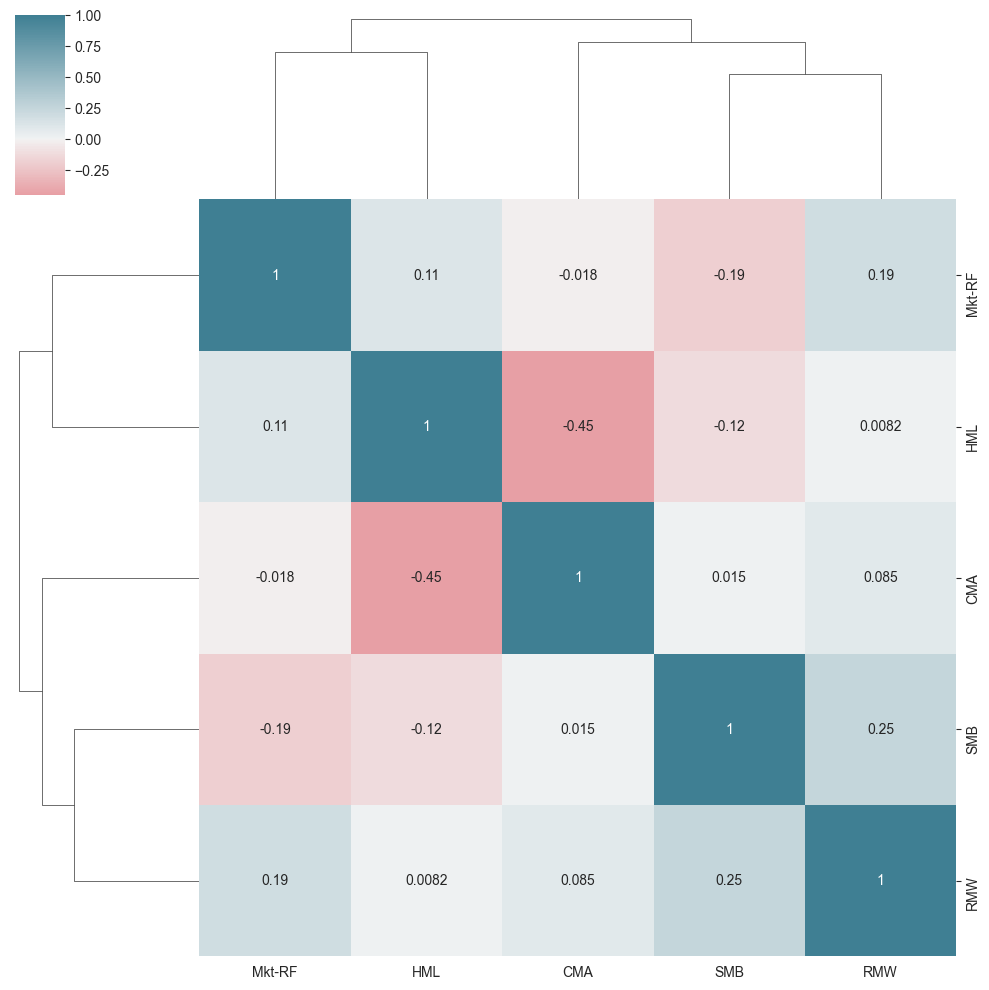

In [26]:
cmap = sns.diverging_palette(10, 220, as_cmap=True)
sns.clustermap(betas.corr(), annot=True, cmap=cmap, center=0);

In [ ]:
data = (data
        .join(betas
              .groupby(level='ticker')
              .shift()))
data.info()
data.head(30)

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 360752 entries, ('A', Timestamp('2001-01-31 00:00:00')) to ('ZUMZ', Timestamp('2018-03-31 00:00:00'))
Data columns (total 11 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   return_1m   360752 non-null  float64
 1   return_2m   360752 non-null  float64
 2   return_3m   360752 non-null  float64
 3   return_6m   360752 non-null  float64
 4   return_9m   360752 non-null  float64
 5   return_12m  360752 non-null  float64
 6   Mkt-RF      316640 non-null  float64
 7   SMB         316640 non-null  float64
 8   HML         316640 non-null  float64
 9   RMW         316640 non-null  float64
 10  CMA         316640 non-null  float64
dtypes: float64(11)
memory usage: 39.8+ MB


return_1m  return_2m  return_3m  return_6m  return_9m  \
ticker date                                                                
A      2001-01-31  -0.003653   0.022360   0.056104   0.049811  -0.052500   
       2001-02-28  -0.329564  -0.189115  -0.116435  -0.084141  -0.076425   
       2001-03-31  -0.146389  -0.249443  -0.175116  -0.074628  -0.092690   
       2001-04-30   0.269444   0.040966  -0.105747  -0.028185  -0.004837   
       2001-05-31  -0.140220   0.044721  -0.023317  -0.071042  -0.064299   
       2001-06-30  -0.031008  -0.087246   0.018842  -0.083252  -0.044465   
       2001-07-31  -0.119692  -0.076414  -0.098192  -0.101978  -0.052105   
       2001-08-31  -0.073750  -0.097014  -0.075527  -0.049781  -0.072540   
       2001-09-30  -0.262264  -0.173364  -0.155847  -0.072607  -0.108119   
       2001-10-31   0.139130  -0.083279  -0.080114  -0.089198  -0.094748   
       2001-11-30   0.224517   0.181052   0.009593  -0.033904  -0.030388   
       2001-12-31   0.045471   0.131458   0.134010  -0.021594  -0.008297   
       2002-01-31   0.064539   0.054962   0.108697   0.009889  -0.027506   
       2002-02-28   0.026359   0.045275   0.045340   0.027311  -0.008180   
       2002-03-31   0.122311   0.073264   0.070347   0.101719   0.008140   
       2002-04-30  -0.140446  -0.017815  -0.003306   0.051205   0.005471   
       2002-05-31  -0.122463  -0.131501  -0.054015  -0.005578  -0.000546   
       2002-06-30  -0.103148  -0.112858  -0.122151  -0.030669   0.021380   
       2002-07-31  -0.201691  -0.153853  -0.143516  -0.076067  -0.018181   
       2002-08-31  -0.288665  -0.246432  -0.201414  -0.130833  -0.075682   
       2002-09-30  -0.027550  -0.168293  -0.179578  -0.151350  -0.083089   
       2002-10-31   0.052833   0.011843  -0.100295  -0.122171  -0.084214   
       2002-11-30   0.411636   0.219105   0.130620  -0.049791  -0.051201   
       2002-12-31  -0.074704   0.142883   0.112042  -0.044833  -0.071334   
       2003-01-31  -0.082405  -0.078563   0.062229  -0.022404  -0.064567   
       2003-02-28  -0.199029  -0.142698  -0.120607  -0.002875  -0.074008   
       2003-03-31  -0.003788  -0.106727  -0.098692   0.001145  -0.063135   
       2003-04-30   0.218251   0.101652  -0.009392   0.025794  -0.018086   
       2003-05-31   0.131710   0.174184   0.111581  -0.011306   0.033904   
       2003-06-30   0.078323   0.104694   0.141319   0.014238   0.045844   
       2003-07-31   0.111509   0.094790   0.106961   0.047170   0.052166   
       2003-08-31   0.119190   0.115343   0.102864   0.107214   0.025373   
       2003-09-30  -0.090872   0.008706   0.041871   0.090462   0.023367   
       2003-10-31   0.127092   0.012260   0.046717   0.076418   0.047019   
       2003-11-30   0.134831   0.130955   0.051571   0.076912   0.088347   
       2003-12-31   0.033946   0.083215   0.097647   0.069396   0.092852   
       2004-01-31   0.260602   0.141663   0.139381   0.092067   0.097009   
       2004-02-29  -0.072436   0.081337   0.065303   0.058415   0.073028   
       2004-03-31  -0.074876  -0.073657   0.026535   0.061496   0.054914   
       2004-04-30  -0.146064  -0.111182  -0.098450   0.013513   0.024463   
       2004-05-31  -0.048501  -0.098601  -0.090761  -0.015818   0.006151   
       2004-06-30   0.139300   0.041174  -0.025405   0.000228   0.031700   
       2004-07-31  -0.186817  -0.037473  -0.041163  -0.070248  -0.005050   
       2004-08-31  -0.139017  -0.163258  -0.072586  -0.081719  -0.035116   
       2004-09-30   0.052195  -0.048201  -0.096850  -0.061808  -0.033239   
       2004-10-31   0.161799   0.105640   0.017202  -0.012411  -0.041967   
       2004-11-30  -0.086592   0.030144   0.037442  -0.019113  -0.043602   
       2004-12-31   0.052862  -0.019341   0.037661  -0.031928  -0.029759   
       2005-01-31  -0.082573  -0.017186  -0.040888  -0.012270  -0.021996   
       2005-02-28   0.085482  -0.002077   0.015910   0.026620  -0.007575   

                   return_12m    Mkt-RF       SMB       HML       

### Impute mean for missing factor betas

In [ ]:
data.loc[:, factors] = data.groupby('ticker')[factors].apply(lambda x: x.fillna(x.mean()))
data.info()

## Momentum factors

We can use these results to compute momentum factors based on the difference between returns over longer periods and the most recent monthly return, as well as for the difference between 3 and 12 month returns as follows:

In [ ]:
for lag in [2,3,6,9,12]:
    data[f'momentum_{lag}'] = data[f'return_{lag}m'].sub(data.return_1m)
data[f'momentum_3_12'] = data[f'return_12m'].sub(data.return_3m)

## Date Indicators

In [ ]:
dates = data.index.get_level_values('date')
data['year'] = dates.year
data['month'] = dates.month

## Lagged returns

To use lagged values as input variables or features associated with the current observations, we use the .shift() method to move historical returns up to the current period:

In [ ]:
for t in range(1, 7):
    data[f'return_1m_t-{t}'] = data.groupby(level='ticker').return_1m.shift(t)
data.info()

## Target: Holding Period Returns

Similarly, to compute returns for various holding periods, we use the normalized period returns computed previously and shift them back to align them with the current financial features

In [ ]:
for t in [1,2,3,6,12]:
    data[f'target_{t}m'] = data.groupby(level='ticker')[f'return_{t}m'].shift(-t)

In [ ]:
cols = ['target_1m',
        'target_2m',
        'target_3m', 
        'return_1m',
        'return_2m',
        'return_3m',
        'return_1m_t-1',
        'return_1m_t-2',
        'return_1m_t-3']

data[cols].dropna().sort_index().head(10)

In [ ]:
data.info()

## Create age proxy

We use quintiles of IPO year as a proxy for company age.

In [ ]:
data = (data
        .join(pd.qcut(stocks.ipoyear, q=5, labels=list(range(1, 6)))
              .astype(float)
              .fillna(0)
              .astype(int)
              .to_frame('age')))
data.age = data.age.fillna(-1)

## Create dynamic size proxy

We use the marketcap information from the NASDAQ ticker info to create a size proxy.

In [ ]:
stocks.info()

Market cap information is tied to currrent prices. We create an adjustment factor to have the values reflect lower historical prices for each individual stock:

In [ ]:
size_factor = (monthly_prices
               .loc[data.index.get_level_values('date').unique(),
                    data.index.get_level_values('ticker').unique()]
               .sort_index(ascending=False)
               .pct_change()
               .fillna(0)
               .add(1)
               .cumprod())
size_factor.info()

In [ ]:
msize = (size_factor
         .mul(stocks
              .loc[size_factor.columns, 'marketcap'])).dropna(axis=1, how='all')

### Create Size indicator as deciles per period

Compute size deciles per month:

In [ ]:
data['msize'] = (msize
                 .apply(lambda x: pd.qcut(x, q=10, labels=list(range(1, 11)))
                        .astype(int), axis=1)
                 .stack()
                 .swaplevel())
data.msize = data.msize.fillna(-1)

## Combine data

In [ ]:
data = data.join(stocks[['sector']])
data.sector = data.sector.fillna('Unknown')

In [ ]:
data.info()

## Store data

We will use the data again in several later chapters, starting in [Chapter 7 on Linear Models](../07_linear_models).

In [ ]:
with pd.HDFStore(DATA_STORE) as store:
    store.put('engineered_features', data.sort_index().loc[idx[:, :datetime(2018, 3, 1)], :])
    print(store.info())

## Create Dummy variables

For most models, we need to encode categorical variables as 'dummies' (one-hot encoding):

In [ ]:
dummy_data = pd.get_dummies(data,
                            columns=['year','month', 'msize', 'age',  'sector'],
                            prefix=['year','month', 'msize', 'age', ''],
                            prefix_sep=['_', '_', '_', '_', ''])
dummy_data = dummy_data.rename(columns={c:c.replace('.0', '') for c in dummy_data.columns})
dummy_data.info()